In [ ]:
import xgboost as xgb

# Initialize the XGBoost classifier
# The 'objective' parameter is for multi-class classification
xgb_model = xgb.XGBClassifier(objective='multi:softmax',
                                 num_class=len(np.unique(y_train)), # Number of unique classes
                                 eval_metric='mlogloss',
                                 use_label_encoder=False,
                                 random_state=42)

# Train the model
xgb_model.fit(X_train_scaled, y_train)

# Make predictions
y_pred_xgb = xgb_model.predict(X_test_scaled)

# Evaluate
from sklearn.metrics import classification_report
print("\n--- XGBoost Classification Report ---")
target_names = [f'Class {i}' for i in np.unique(y_train)]
print(classification_report(y_test, y_pred_xgb, target_names=target_names, zero_division=0))


--- XGBoost Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.86      0.89      0.87        35
     Class 1       0.18      0.15      0.17        13
     Class 2       0.33      0.40      0.36         5
     Class 3       0.17      0.25      0.20         4
     Class 4       0.00      0.00      0.00         3

    accuracy                           0.60        60
   macro avg       0.31      0.34      0.32        60
weighted avg       0.58      0.60      0.59        60



/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [10:46:11] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Improved RF model

In [ ]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

param_dist = {
    'n_estimators': [50, 100, 150, 200, 250],   # Number of trees
    'max_features': ['sqrt', 'log2', None],      # Number of features to consider at each split
    'max_depth': [5, 10, 20, 30, None],       # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],           # Minimum number of samples to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum number of samples at a leaf node
    'bootstrap': [True, False],                 # Method for sampling data points
    'class_weight': ['balanced', None]
}


rf_model = RandomForestClassifier(random_state=42)


# 'scoring' is crucial; 'f1_weighted' is good for multi-class imbalanced data
random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_dist,
                                   n_iter=50, scoring='f1_weighted', cv=5, verbose=1, n_jobs=-1, random_state=42)

#  Run the random search on your training data
print("Starting Randomized Search for optimal hyperparameters...")
random_search.fit(X_train_scaled, y_train)

# Get the best parameters and best model
print("\n--- Hyperparameter Tuning Results ---")
print("Best parameters found: ", random_search.best_params_)
print("Best cross-validation score: {:.4f}".format(random_search.best_score_))

# Use the best model to make predictions on the test set
best_rf_model = random_search.best_estimator_
y_pred = best_rf_model.predict(X_test_scaled)

#  Final evaluation with the best model
print("\n--- Final Evaluation with Best Model ---")
print(classification_report(y_test, y_pred, zero_division=0))

Starting Randomized Search for optimal hyperparameters...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

--- Hyperparameter Tuning Results ---
Best parameters found:  {'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_features': 'log2', 'max_depth': 30, 'class_weight': 'balanced', 'bootstrap': True}
Best cross-validation score: 0.5799

--- Final Evaluation with Best Model ---
              precision    recall  f1-score   support

           0       0.89      0.89      0.89        35
           1       0.25      0.23      0.24        13
           2       0.17      0.20      0.18         5
           3       0.20      0.25      0.22         4
           4       0.00      0.00      0.00         3

    accuracy                           0.60        60
   macro avg       0.30      0.31      0.31        60
weighted avg       0.60      0.60      0.60        60



Improved Logistic Regression

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],             # Regularization penalty(lasso,ridge)
    'solver': ['liblinear', 'saga'],     # Optimization algorithm
    'class_weight': ['balanced', None]
}

lr_model_improved = LogisticRegression(random_state=42, max_iter=1000)
grid_search = GridSearchCV(estimator=lr_model_improved, param_grid=param_grid,
                           cv=5, scoring='f1_weighted', verbose=1, n_jobs=-1)

#  Run the grid search on your scaled training data
print("Starting Grid Search for optimal hyperparameters...")

grid_search.fit(X_train_scaled, y_train)

# 5. Get the best parameters and best model
print("\n--- Hyperparameter Tuning Results ---")
print("Best parameters found: ", grid_search.best_params_)
print("Best cross-validation score: {:.4f}".format(grid_search.best_score_))

# Use the best model to make predictions on the test set
best_lr_model = grid_search.best_estimator_
y_pred = best_lr_model.predict(X_test_scaled)


best_params = grid_search.best_params_

final_lr_model = LogisticRegression(
    random_state=42,
    max_iter=1000,
    **best_params 
)

# Fit this new model on the ENTIRE training dataset
print("Fitting final model on the entire training dataset...")
final_lr_model.fit(X_train_scaled, y_train)
print("Final model has been fitted successfully.")


# Evaluate the Final Model on the Test Set
y_pred_final = final_lr_model.predict(X_test_scaled)
final_accuracy = accuracy_score(y_test, y_pred_final)

print("\n--- Final Model Evaluation ---")
print(f"Accuracy on test set: {final_accuracy:.4f}")
print("Classification Report:")
print(classification_report(y_test, y_pred_final, zero_division=0))

print("\n--- Final Evaluation with Best Model ---")
print(classification_report(y_test, y_pred, zero_division=0))

Starting Grid Search for optimal hyperparameters...
Fitting 5 folds for each of 48 candidates, totalling 240 fits

--- Hyperparameter Tuning Results ---
Best parameters found:  {'C': 1, 'class_weight': None, 'penalty': 'l2', 'solver': 'saga'}
Best cross-validation score: 0.5563
Fitting final model on the entire training dataset...
Final model has been fitted successfully.

--- Final Model Evaluation ---
Accuracy on test set: 0.6333
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.91      0.90        35
           1       0.50      0.46      0.48        13
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3

    accuracy                           0.63        60
   macro avg       0.28      0.28      0.28        60
weighted avg       0.63      0.63      0.63        60


--- Final Evaluation with Best Model ---
          

Applying PCA


Original dimensions: X_train.shape = (239, 25)
Transformed dimensions: X_train_pca.shape = (239, 2)

Explained variance ratio by each principal component: [0.18911451 0.1057843 ]
Total explained variance by the components: 0.2949

Training Logistic Regression model on PCA-transformed data...

--- Final Evaluation on PCA-Transformed Data ---
              precision    recall  f1-score   support

           0       0.80      0.91      0.85        35
           1       0.29      0.15      0.20        13
           2       0.00      0.00      0.00         5
           3       0.17      0.50      0.25         4
           4       0.00      0.00      0.00         3

    accuracy                           0.60        60
   macro avg       0.25      0.31      0.26        60
weighted avg       0.54      0.60      0.56        60


Plotting explained variance to find optimal number of components...


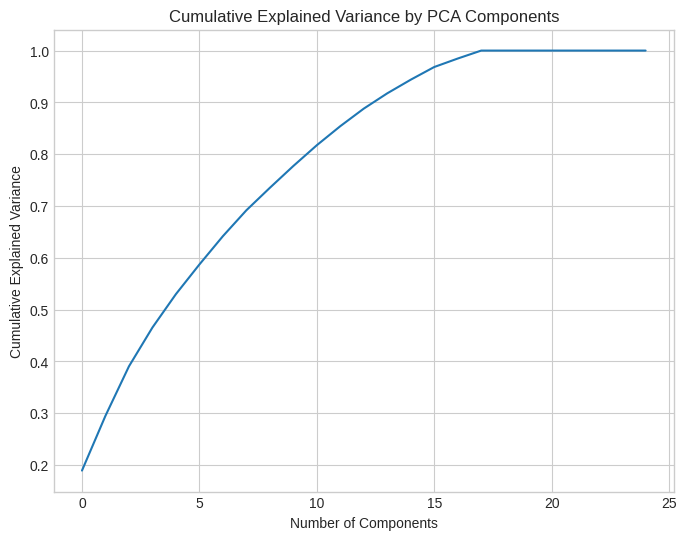

In [74]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 2: Apply PCA on the scaled training data
# We'll use 2 principal components for easy visualization
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train_scaled)

# Step 3: Transform the test data using the SAME PCA object
X_test_pca = pca.transform(X_test_scaled)

print(f"\nOriginal dimensions: X_train.shape = {X_train.shape}")
print(f"Transformed dimensions: X_train_pca.shape = {X_train_pca.shape}")
print(f"\nExplained variance ratio by each principal component: {pca.explained_variance_ratio_}")
print(f"Total explained variance by the components: {np.sum(pca.explained_variance_ratio_):.4f}")

# Step 4: Train a new model on the PCA-transformed data
print("\nTraining Logistic Regression model on PCA-transformed data...")
pca_model = LogisticRegression(random_state=42, solver='saga', max_iter=1000)
pca_model.fit(X_train_pca, y_train)

# Step 5: Evaluate the model
y_pred_pca = pca_model.predict(X_test_pca)
print("\n--- Final Evaluation on PCA-Transformed Data ---")
print(classification_report(y_test, y_pred_pca, zero_division=0))

# Optional: You can also use the explained variance ratio to decide how many components to keep
print("\nPlotting explained variance to find optimal number of components...")
pca_full = PCA(n_components=None)
pca_full.fit(X_train_scaled)
plt.figure(figsize=(8, 6))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance by PCA Components')
plt.grid(True)
plt.show()


--- Multi-Class Model Evaluation ---
Accuracy: 0.6500

Confusion Matrix:


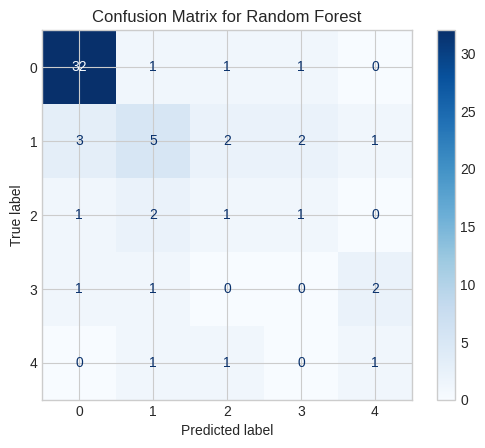


Classification Report:
              precision    recall  f1-score   support

     Class 0       0.86      0.91      0.89        35
     Class 1       0.50      0.38      0.43        13
     Class 2       0.20      0.20      0.20         5
     Class 3       0.00      0.00      0.00         4
     Class 4       0.25      0.33      0.29         3

    accuracy                           0.65        60
   macro avg       0.36      0.37      0.36        60
weighted avg       0.64      0.65      0.64        60



In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf_model_pca = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')

#  Train the model on the scaled training data
rf_model_pca.fit(X_train_pca, y_train)

#  Make predictions on the scaled test data
y_pred = rf_model_pca.predict(X_test_pca)

#  Evaluate the model using multi-class metrics
print("\n--- Multi-Class Model Evaluation ---")

# a. Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")

# b. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y))
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for Random Forest')
plt.show()

# c. Classification Report (most comprehensive for multi-class)
print("\nClassification Report:")
# The 'target_names' parameter helps with interpreting the report
target_names = [f'Class {i}' for i in np.unique(y)]
print(classification_report(y_test, y_pred, target_names=target_names, zero_division=0))

Improved SVM

Training the SVM model...
Making predictions on the test set...

--- Model Evaluation ---
Accuracy: 0.5667

Confusion Matrix:


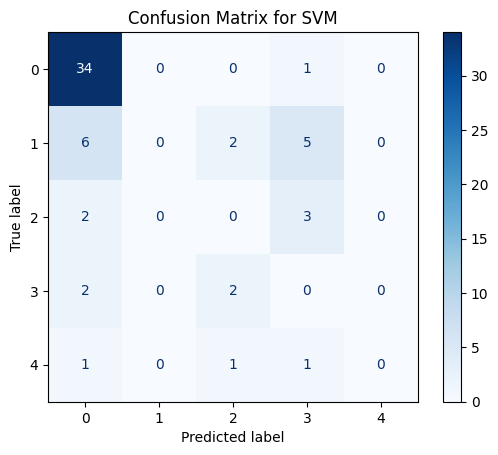


Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85        35
           1       0.00      0.00      0.00        13
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00         4
           4       0.00      0.00      0.00         3

    accuracy                           0.57        60
   macro avg       0.15      0.19      0.17        60
weighted avg       0.44      0.57      0.50        60



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
svm_model = SVC(kernel='rbf', C=1.0, random_state=42)

#  Train the model on the training data
print("Training the SVM model...")
svm_model.fit(X_train_pca, y_train)

#  Make predictions on the test data
print("Making predictions on the test set...")
y_pred = svm_model.predict(X_test_pca)

#  Evaluate the model using classification metrics
print("\n--- Model Evaluation ---")

#  Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")



# Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=svm_model.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix for SVM')
plt.show()

# Classification Report (combines precision, recall, f1-score)
from sklearn.metrics import classification_report
print("\nClassification Report:")
print(classification_report(y_test, y_pred, zero_division=0))